# Image Captioning with Visual Attention

## Creating Data Structure

In [1]:
!mkdir data
%cd data
!mkdir raw external processed
!mkdir processed/train processed/test

/content/data


In [2]:
!apt-get -qq install tree

Selecting previously unselected package tree.
(Reading database ... 144628 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [3]:
!tree .

.
├── external
├── processed
│   ├── test
│   └── train
└── raw

5 directories, 0 files


## Downloading Data



In [4]:
!wget -q http://13.234.225.243:9600/train_data.tar -O external/train_data.tar

In [5]:
!wget -q http://13.234.225.243:9600/test_data.tar -O external/test_data.tar 

In [6]:
!tar -xf external/train_data.tar -C raw/

In [7]:
!tar -xf external/test_data.tar -C raw/

In [8]:
!wget -q http://13.234.225.243:9600/train_data.csv -O raw/train_data/train_data.csv

In [9]:
!wget -q http://13.234.225.243:9600/sample_submission.csv -O raw/test_data/sample_submission.csv

### Utility Functions

In [10]:
import matplotlib.pyplot as plt
import tensorflow as tf


def plot_grid(files, labels=None, h=5, w=5, title=""):
    f, ax = plt.subplots(h, w, figsize=(18, 18))
    random_indexes = random.sample(range(len(files)), k=h*w)
    for i, j in enumerate(random_indexes):
        image = tf.io.read_file(files[j])
        image = tf.image.decode_jpeg(image, 3)
        image = tf.cast(image/255, tf.float32)
        label = labels[j]

        ax[i // h, i % w].imshow(image)
        ax[i // h, i % w].axis("off")
        ax[i // h, i % w].set_title(label)
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

## Extract DateField

In [11]:
from glob import glob

import cv2 as cv
import numpy as np
from tqdm import tqdm


class ExtractRectangle:
    def __init__(self):
        super().__init__()

        self.minLinLength_h = 70
        self.minLinLength_v = 5
        self.maxLineGap = 20

    def is_horizontal(self, line, thresh=5):
        return abs(line[1] - line[3]) <= thresh

    def is_vertical(self, line, thresh=5):
        return abs(line[0] - line[2]) <= thresh

    def get_lines(self, canny, horizontal=True):
        lines = []
        if horizontal:
            linesP = cv.HoughLinesP(
                canny,
                rho=1,
                theta=np.pi / 180,
                threshold=10,
                lines=None,
                minLineLength=self.minLinLength_h,
                maxLineGap=20,
            )
        else:
            linesP = cv.HoughLinesP(
                canny,
                rho=1,
                theta=np.pi / 180,
                threshold=10,
                lines=None,
                minLineLength=self.minLinLength_v,
                maxLineGap=20,
            )
        if linesP is not None:
            for i in range(0, len(linesP)):
                l = linesP[i][0]
                if self.is_horizontal(l, 3) and horizontal:
                    lines.append(l)
                elif self.is_vertical(l, 3):
                    lines.append(l)
        return lines

    def remove_whitespace(self, img):
        # https://stackoverflow.com/questions/48395434/how-to-crop-or-remove-white-background-from-an-image
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        th, threshed = cv.threshold(gray, 127, 255, cv.THRESH_BINARY_INV)

        kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (11, 11))
        morphed = cv.morphologyEx(threshed, cv.MORPH_CLOSE, kernel)

        cnts = cv.findContours(morphed, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[-2]
        cnt = sorted(cnts, key=cv.contourArea)[-1]

        x, y, w, h = cv.boundingRect(cnt)
        dst = img[y : y + h, x : x + w]
        return dst

    def process_image(self, filename, path):
        errenous = False
        img = cv.imread(cv.samples.findFile(filename))
        img = self.remove_whitespace(img)
        cImage = np.copy(img)

        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        canny = cv.Canny(gray, 100, 200)

        horizontal_lines = self.get_lines(canny)
        horizontal_lines = sorted(horizontal_lines, key=lambda a_entry: a_entry[..., 1])

        vertical_lines = self.get_lines(canny, horizontal=False)
        vertical_lines = sorted(vertical_lines, key=lambda a_entry: a_entry[..., 0])

        if len(horizontal_lines) > 0:
            initial_line = horizontal_lines[0]
            final_line = horizontal_lines[-1]

            # LeftTop(x1, y1) -> RightTop(x2, y1) -> RightBottom(x2, y2) -> LeftBottom(x1, y2)
            y1 = initial_line[1]
            y2 = final_line[1]
            bottom = min(y1, y2)
            top = max(y1, y2)

            # post whitespace removal, dates should only be the major component
            if (top - bottom) / img.shape[0] < 0.6:
                errenous = True
        else:
            errenous = True

        if len(vertical_lines) > 0:
            initial_line = vertical_lines[0]
            final_line = vertical_lines[-1]

            x1 = initial_line[0]
            x2 = final_line[0]
            left = min(x1, x2)
            right = max(x1, x2)

            # as dates occupy majority of the horizontal space
            if (right - left) / img.shape[1] < 0.9:
                errenous = True
        else:
            errenous = True

        if not errenous:
            # cImage = cv.rectangle(cImage, (left, bottom), (right, top), (255, 0, 0), 2)
            cImage = cImage[
                bottom : bottom + (top - bottom), left : left + (right - left)
            ]
        cv.imwrite(f"{path}/{filename.split('/')[-1]}", cImage)

In [12]:
extract = ExtractRectangle()
test_files = glob("raw/test_data/*.png")
test_path = "processed/test/"
for path in tqdm(test_files):
    extract.process_image(path, test_path)

train_files = glob("raw/train_data/*.png")
train_path = "processed/train/"
for path in tqdm(train_files):
    extract.process_image(path, train_path)

100%|██████████| 10000/10000 [01:36<00:00, 103.99it/s]


## Image Captioning

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [73]:
import collections
import json
import os
import pickle
from pprint import pprint
import random
import requests
import re
import time
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle
from tqdm import tqdm

In [15]:
TEST_IMAGES_PATH = "processed/test/"
TRAIN_CSV_PATH = "raw/train_data/train_data.csv"
TRAIN_IMAGES_PATH = "processed/train/"
RANDOM_STATE = 42
BATCH_SIZE = 64

In [16]:
PUBLIC_host = "http://13.234.225.243"
SUBMISSION_URL = PUBLIC_host + ":8080/submit"
LEADERBOARD_URL = PUBLIC_host + ":8080/leaderboard"
DATA_URL = PUBLIC_host + ":9600"
TAG = "image_captioning_v1"

In [17]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"


seed_everything(RANDOM_STATE)

### Prepare Dataset

In [18]:
train_df = pd.read_csv(TRAIN_CSV_PATH).sort_values(by="tag")

In [19]:
train_df["length"] = train_df["label"].astype(str).str.len()

In [20]:
train_df = train_df.loc[train_df["length"]==8]

In [21]:
image_paths = train_df["tag"].apply(lambda x: TRAIN_IMAGES_PATH+f"{x}.png").tolist()
labels = train_df["label"].apply(lambda x: f"<start> {' '.join(str(x))} <end>").tolist()

In [22]:
orig_labels = train_df["label"].astype(str).tolist()

In [23]:
len(image_paths), len(labels)

(9020, 9020)

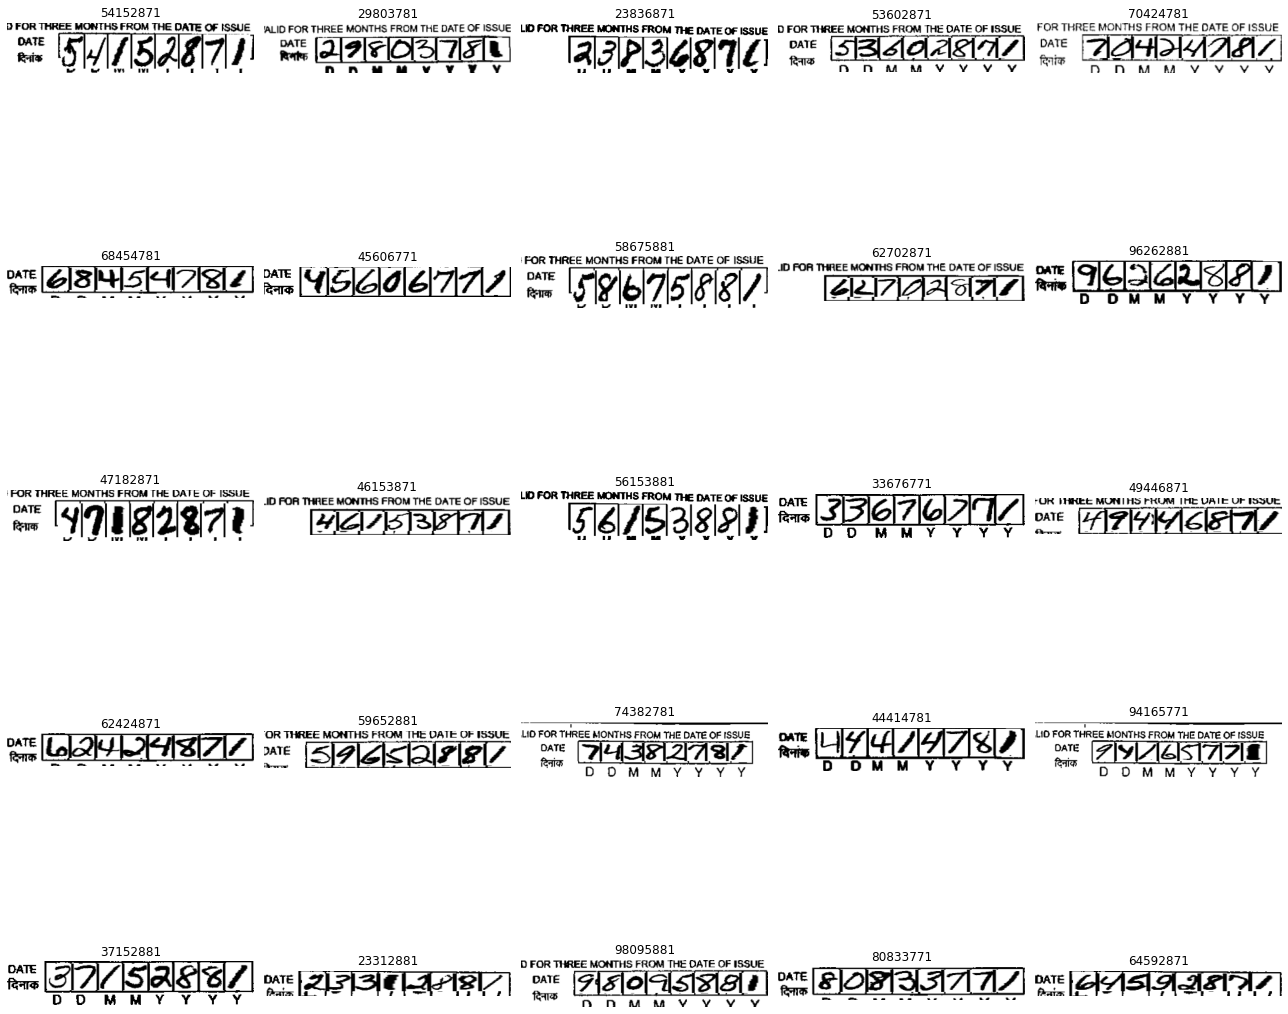

In [24]:
plot_grid(image_paths, orig_labels)

### Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [25]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

### Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you pickle the dictionary and save it to disk.


In [26]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet")
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 2s 0us/step


### Caching the features extracted from InceptionV3

Pre-process each image with InceptionV3 and cache the output to disk.

In [27]:
encode_train = sorted(set(image_paths))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
).batch(BATCH_SIZE)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(
        batch_features, (batch_features.shape[0], -1, batch_features.shape[3])
    )

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|██████████| 141/141 [01:37<00:00,  1.45it/s]


### Tokenize the captions

In [28]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [29]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(labels)
train_seqs = tokenizer.texts_to_sequences(labels)

In [30]:
train_seqs = tokenizer.texts_to_sequences(labels)

In [31]:
train_seqs = tokenizer.texts_to_sequences(labels)

In [32]:
max_length = calc_max_length(train_seqs)

In [33]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(image_paths, train_seqs):
    img_to_cap_vector[img].append(cap)

### Create `tf.data dataset` from training & validation indexes


In [34]:
BUFFER_SIZE = 1000
EMBED_DIM = 256
UNITS = 512
VOCAB_SIZE = len(tokenizer.word_index)+1
EPOCHS = 25
NUM_SPLITS = 4
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Shape of the vector extracted from InceptionV3 is (64, 2048)
features_shape = 2048
attention_features_shape = 64

In [35]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode("utf-8") + ".npy")
    return img_tensor, cap

In [36]:
def get_dataset(train_indexes, valid_indexes):
    # this loop can be pre-computed
    img_name_train, cap_train = [], []
    for imgt in train_indexes:
        imgt = f"processed/train/{imgt}.png"
        capt_len = len(img_to_cap_vector[imgt])
        img_name_train.extend([imgt] * capt_len)
        cap_train.extend(img_to_cap_vector[imgt])

    img_name_val, cap_val = [], []
    for imgv in valid_indexes:
        imgv = f"processed/train/{imgv}.png"
        capv_len = len(img_to_cap_vector[imgv])
        img_name_val.extend([imgv] * capv_len)
        cap_val.extend(img_to_cap_vector[imgv])

    train_dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
    train_dataset = train_dataset.map(
        lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]
        ),
        num_parallel_calls=AUTOTUNE,
    )
    train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

    valid_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))
    valid_dataset = valid_dataset.map(
        lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]
        ),
        num_parallel_calls=AUTOTUNE,
    )
    valid_dataset = valid_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
    return train_dataset, valid_dataset

### Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [37]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis)
        )

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [38]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [39]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            self.units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [40]:
encoder = CNN_Encoder(EMBED_DIM)
decoder = RNN_Decoder(EMBED_DIM, UNITS, VOCAB_SIZE)

In [41]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### Checkpoint

In [42]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [43]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

### Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [44]:
loss_plot, val_loss_plot = [], []

In [45]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index["<start>"]] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = loss / int(target.shape[1])
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, total_loss

In [46]:
@tf.function
def valid_step(img_tensor, target):
    loss = 0

    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index["<start>"]] * target.shape[0], 1)

    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
        predictions, _, _ = decoder(dec_input, features, hidden)
        loss += loss_function(target[:, i], predictions)
        dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = loss / int(target.shape[1])
    return loss, total_loss

In [47]:
kfold = KFold(n_splits=NUM_SPLITS, shuffle=True, random_state=RANDOM_STATE)

In [48]:
for fold, (train_idx, valid_idx) in enumerate(kfold.split(image_paths, labels)):
    print("*"*28)
    print("*"+" "*10+f"FOLD {fold}"+" "*10+"*")
    print("*"*28)
    train_dataset, valid_dataset = get_dataset(train_idx, valid_idx)

    NUM_STEPS = len(train_idx) // BATCH_SIZE
    VAL_NUM_STEPS = len(valid_idx) // BATCH_SIZE

    for epoch in range(start_epoch, EPOCHS):
        start = time.time()
        total_loss, valid_loss = 0, 0

        for (batch, (img_tensor, target)) in enumerate(train_dataset):
            batch_loss, t_loss = train_step(img_tensor, target)
            total_loss += t_loss

        # storing the epoch end loss value to plot later
        loss_plot.append(total_loss / NUM_STEPS)
        if epoch % 5 == 0:
            ckpt_manager.save()

        print("Epoch {} Train Loss {:.6f}".format(epoch + 1, total_loss / NUM_STEPS))

        # validation
        for (batch, (img_tensor, target)) in enumerate(valid_dataset):
            batch_loss, t_loss = valid_step(img_tensor, target)
            valid_loss += t_loss

        val_loss_plot.append(valid_loss / VAL_NUM_STEPS)
        print("Epoch {} Valid Loss {:.6f}".format(epoch + 1, valid_loss / VAL_NUM_STEPS))

        print("Time {} sec\n".format(time.time() - start))

****************************
*          FOLD 0          *
****************************
Epoch 1 Train Loss 1.538997
Epoch 1 Valid Loss 1.627028
Time 97.47920346260071 sec

Epoch 2 Train Loss 1.310536
Epoch 2 Valid Loss 2.045925
Time 42.000181674957275 sec

Epoch 3 Train Loss 1.079677
Epoch 3 Valid Loss 2.254779
Time 7.964270830154419 sec

Epoch 4 Train Loss 0.876293
Epoch 4 Valid Loss 2.548204
Time 7.95351505279541 sec

Epoch 5 Train Loss 0.770815
Epoch 5 Valid Loss 3.109189
Time 7.928861141204834 sec

Epoch 6 Train Loss 0.707438
Epoch 6 Valid Loss 2.935741
Time 7.985753536224365 sec

Epoch 7 Train Loss 0.643049
Epoch 7 Valid Loss 3.258879
Time 7.902261734008789 sec

Epoch 8 Train Loss 0.594110
Epoch 8 Valid Loss 3.592315
Time 7.886916399002075 sec

Epoch 9 Train Loss 0.556379
Epoch 9 Valid Loss 3.594858
Time 7.812854290008545 sec

Epoch 10 Train Loss 0.517933
Epoch 10 Valid Loss 3.936565
Time 7.866094589233398 sec

Epoch 11 Train Loss 0.484946
Epoch 11 Valid Loss 4.184029
Time 7.994250

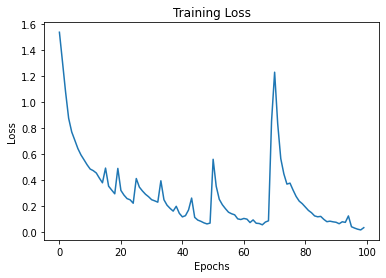

In [50]:
plt.plot(loss_plot)
plt.xlabel("Epochs")
plt.ylabel("Loss" )
plt.title("Training Loss")
plt.show()

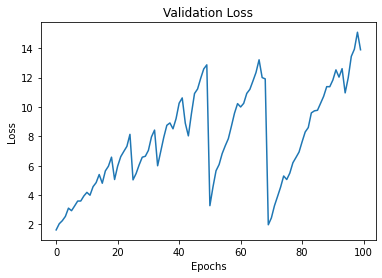

In [51]:
plt.plot(val_loss_plot)
plt.xlabel("Epochs")
plt.ylabel("Loss" )
plt.title("Validation Loss")
plt.show()

## Evaluation
* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [52]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(
        img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3])
    )

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index["<start>"]], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == "<end>":
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[: len(result), :]
    return result, attention_plot

In [53]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result // 2, len_result // 2, l + 1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap="gray", alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [54]:
# # captions on the validation set
# for _ in range(5):
#     rid = np.random.randint(0, 100)
#     image = img_name_val[rid]
#     real_caption = " ".join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
#     result, attention_plot = evaluate(image)

#     print("Real Caption:", real_caption)
#     print("Prediction Caption:", " ".join(result))
#     plot_attention(image, result, attention_plot)

### Entire Training Data Evaluation

In [55]:
count = 0
train_preds, train_matches, train_mismatches = [], [], []
for path, label in tqdm(dict(zip(image_paths, orig_labels)).items()):
    try:
        result, attention_plot = evaluate(path)
        result = "".join(result[:-1])
        train_preds.append(result)

        if len(result) < 8:
            count += 1
            train_mismatches.append({path: result})
            print(f"Image: {path.split('/')[-1]}\tLabel: {label}\tResult: {result}")
        else:
            digit_matches = {}
            for j in range(8):
                digit_matches[j] = result[j]==label[j]
            train_matches.append(digit_matches)
    except Exception:
        count += 1

  2%|▏         | 156/9020 [00:23<20:59,  7.04it/s]

Image: 164.png	Label: 88862871	Result: 8886881


  6%|▌         | 545/9020 [01:18<19:19,  7.31it/s]

Image: 590.png	Label: 68774781	Result: 6877771


  8%|▊         | 680/9020 [01:38<19:20,  7.19it/s]

Image: 739.png	Label: 68155781	Result: 6815781


 10%|█         | 909/9020 [02:10<18:42,  7.23it/s]

Image: 989.png	Label: 24126871	Result: 2415881


 10%|█         | 930/9020 [02:13<18:58,  7.11it/s]

Image: 1014.png	Label: 58014771	Result: 5804771


 14%|█▍        | 1248/9020 [02:59<18:10,  7.13it/s]

Image: 1364.png	Label: 87325781	Result: 8733771


 16%|█▋        | 1485/9020 [03:32<17:25,  7.21it/s]

Image: 1622.png	Label: 28074771	Result: 2804771


 26%|██▌       | 2313/9020 [05:31<15:39,  7.14it/s]

Image: 2545.png	Label: 90345781	Result: 9054771


 29%|██▉       | 2655/9020 [06:20<15:08,  7.01it/s]

Image: 2922.png	Label: 69745781	Result: 6974781


 33%|███▎      | 2932/9020 [07:00<13:54,  7.30it/s]

Image: 3231.png	Label: 59792771	Result: 3979771


 34%|███▍      | 3053/9020 [07:16<13:27,  7.39it/s]

Image: 3364.png	Label: 32844881	Result: 1234581


 38%|███▊      | 3463/9020 [08:14<12:51,  7.20it/s]

Image: 3814.png	Label: 20632881	Result: 2063881


 39%|███▉      | 3542/9020 [08:25<12:33,  7.27it/s]

Image: 3899.png	Label: 63894871	Result: 4384881


 49%|████▉     | 4430/9020 [10:30<11:16,  6.78it/s]

Image: 4889.png	Label: 89336771	Result: 4936771


 70%|██████▉   | 6286/9020 [14:52<06:24,  7.12it/s]

Image: 6941.png	Label: 41153881	Result: 4115881


 71%|███████   | 6386/9020 [15:06<06:20,  6.92it/s]

Image: 7052.png	Label: 55816781	Result: 3581671


 72%|███████▏  | 6455/9020 [15:16<05:56,  7.20it/s]

Image: 7125.png	Label: 30113881	Result: 3017881


 73%|███████▎  | 6577/9020 [15:33<05:44,  7.09it/s]

Image: 7263.png	Label: 33025871	Result: 3302881


 75%|███████▍  | 6751/9020 [15:58<05:09,  7.33it/s]

Image: 7462.png	Label: 21154781	Result: 211


 83%|████████▎ | 7475/9020 [17:41<03:38,  7.06it/s]

Image: 8276.png	Label: 25585771	Result: 2585771


 89%|████████▊ | 7994/9020 [18:54<02:27,  6.97it/s]

Image: 8851.png	Label: 41423771	Result: 4142771


 98%|█████████▊| 8867/9020 [21:00<00:22,  6.84it/s]

Image: 9827.png	Label: 38115771	Result: 3111


 98%|█████████▊| 8872/9020 [21:01<00:22,  6.68it/s]

Image: 9832.png	Label: 25594781	Result: 5254781


100%|██████████| 9020/9020 [21:22<00:00,  7.03it/s]


In [56]:
tokenizer.index_word

{1: '8',
 2: '7',
 3: '1',
 4: '<start>',
 5: '<end>',
 6: '4',
 7: '5',
 8: '3',
 9: '2',
 10: '6',
 11: '9',
 12: '0'}

In [62]:
result_df = pd.DataFrame(train_matches)
temp = pd.DataFrame()
temp["# Positionwise Correct Preds"] = result_df.sum()
temp["% Positionwise Accuracy"] = result_df.sum()/len(result_df)*100

In [61]:
temp

,# Positionwise Correct Preds,% Positionwise Accuracy
0,7866,87.429143
1,7156,79.537624
2,7023,78.059353
3,7122,79.159720
4,7779,86.462154
5,8610,95.698566
6,8774,97.521396
7,8939,99.355341


**The entire training data has either [771, 781, 871, 881] as the last 3 digit. On the other hand this is not the case with testing data. Refer my [exploration notebook](initial_exploration.ipynb)**

### Test Data Prediction

In [64]:
test_image_paths = [f"processed/test/{x}.png" for x in range(1000)]

In [65]:
# prediction on test set
preds = []
for path in tqdm(test_image_paths):
    result, _ = evaluate(path)
    result = "".join(result[:-1])
    preds.append(result)

100%|██████████| 1000/1000 [02:25<00:00,  6.87it/s]


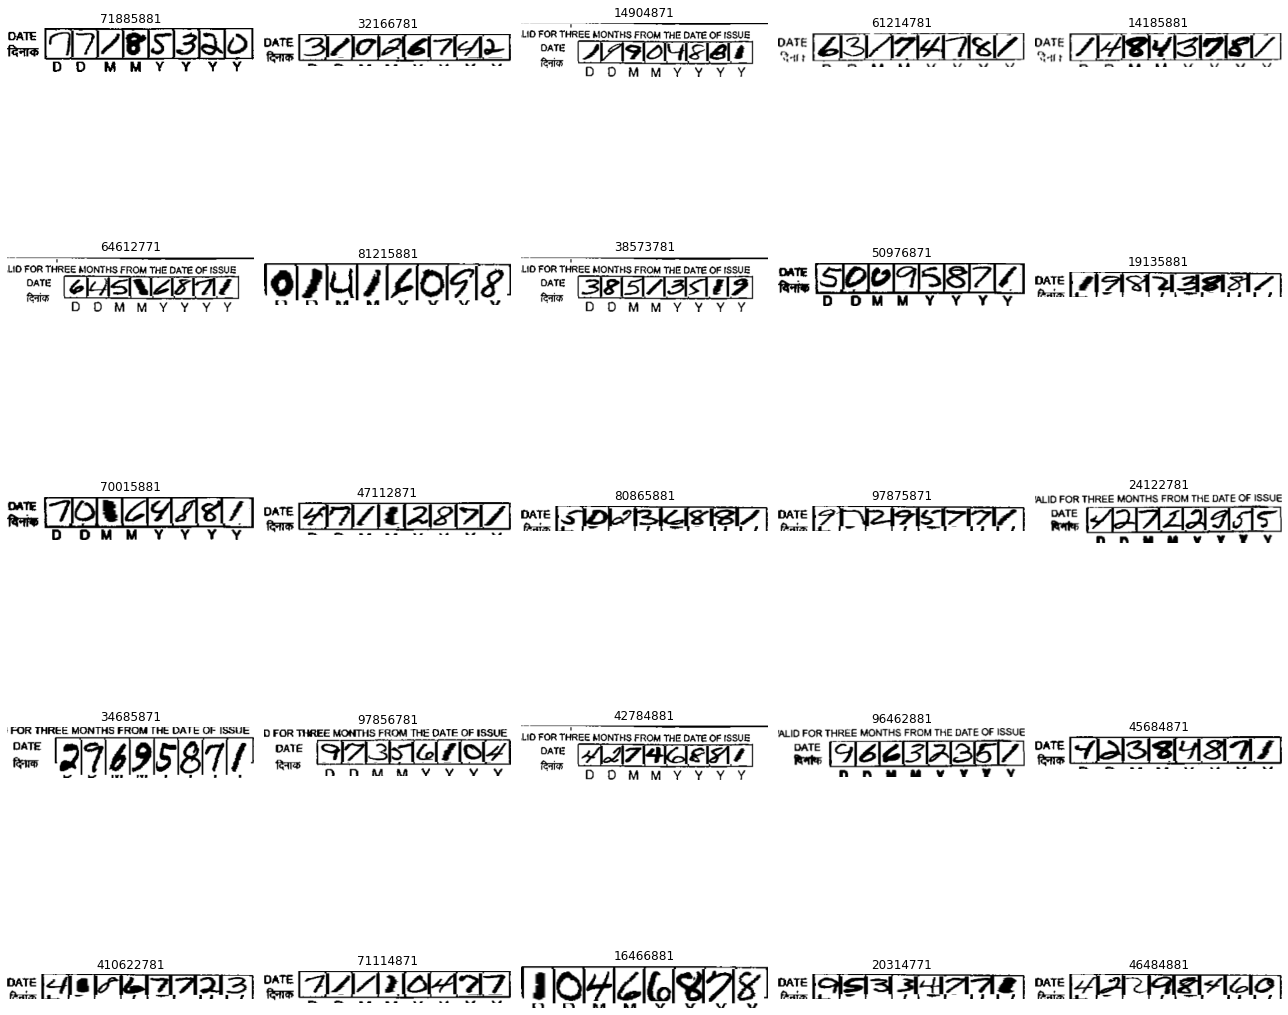

In [66]:
plot_grid(test_image_paths, preds, h=6, w=6)

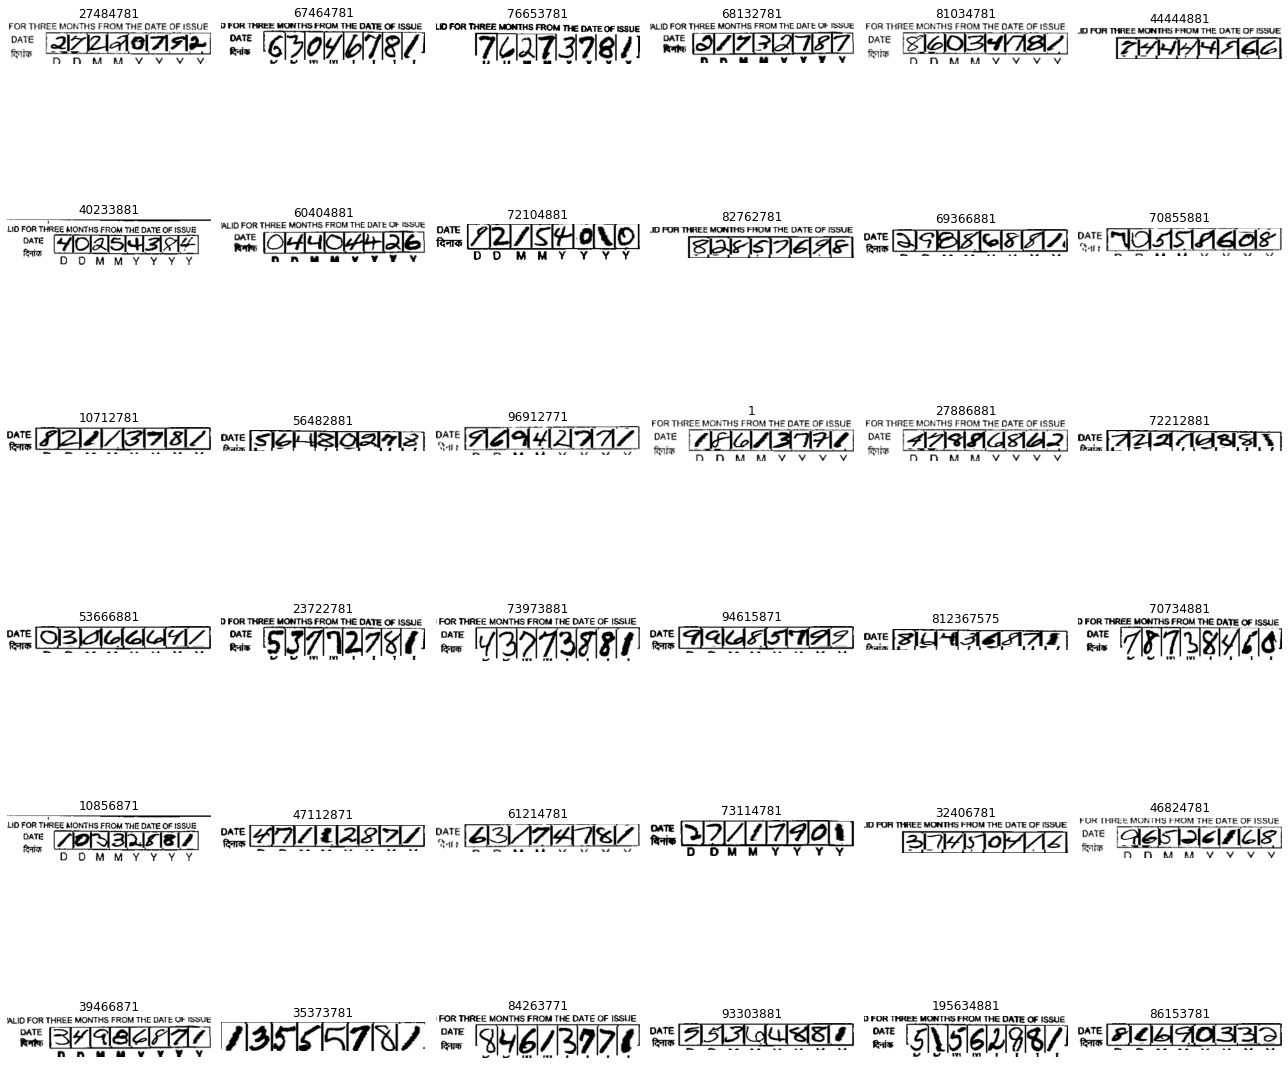

In [67]:
plot_grid(test_image_paths, preds, h=6, w=6)

In [70]:
sub_df = pd.DataFrame()
sub_df["tag"] = np.arange(0, 1000)
sub_df["label"] = preds
sub_df.to_csv(f"submission_image_captioning_kfold.csv", index=False)

In [71]:
sub_df.head()

,tag,label
0,0,79085871
1,1,174654881
2,2,29182881
3,3,21714881
4,4,85252781


In [83]:
sample = pd.read_csv("raw/test_data/sample_submission.csv")

In [85]:
sub_df = sub_df.set_index("tag")
sub_df = sub_df.reindex(index=sample["tag"])
sub_df = sub_df.reset_index()

In [86]:
sub_df.head()

,tag,label
0,667,74614881
1,733,93356881
2,530,80073871
3,779,61806881
4,775,16006881


In [87]:
sub_json = sub_df.to_json()
data = {
    "username": "aditya",
    "password": "sdhjbj@8676",
    "submission": sub_json,
    "tag": "aditya_v2",
}
r = requests.post(SUBMISSION_URL, json=data)

In [88]:
r.text

'{"success":true,"score":0.019}'

In [89]:
rl = requests.post(LEADERBOARD_URL, json={})
pprint(rl.json())

{'leaderboard': [{'score': 0.362,
                  'submitted_at': '2020-10-30-12-30-1604061007',
                  'tag': 'raj_test3',
                  'username': 'raj'},
                 {'score': 0.362,
                  'submitted_at': '2020-10-30-12-39-1604061549',
                  'tag': 'raj_test4',
                  'username': 'raj'},
                 {'score': 0.189,
                  'submitted_at': '2020-10-30-13-05-1604063139',
                  'tag': 'raj_test5',
                  'username': 'raj'},
                 {'score': 0.189,
                  'submitted_at': '2020-10-30-13-23-1604064186',
                  'tag': 'raj_test6',
                  'username': 'raj'},
                 {'score': 0.019,
                  'submitted_at': '2020-10-30-18-46-1604083586',
                  'tag': 'aditya_v1',
                  'username': 'aditya'},
                 {'score': 0.019,
                  'submitted_at': '2020-10-30-18-56-1604084186',
                  'tag'